In [159]:
import gymnasium as gym
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

#from ddpg import DDPGAgent

In [160]:
BATCH_SIZE = 256
LR = 0.001
TAU = 0.001
GAMMA = 0.99
EPOCHS = 2000
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

env = gym.make('Pendulum-v1')

In [161]:
class DDPGCritic(nn.Module):
    def __init__(self, num_state, num_action, n_hidden_action=16, n_hidden_state=32, n_hidden=256):
        super().__init__()
        self.state_net  = nn.Linear(in_features=num_state, out_features=n_hidden_state)
        self.action_net = nn.Linear(in_features=num_action, out_features=n_hidden_action)
        self.linear1 = nn.Linear(in_features=(n_hidden_state + n_hidden_action), out_features=n_hidden)
        self.linear2 = nn.Linear(in_features=n_hidden, out_features=n_hidden)
        self.linear3 = nn.Linear(in_features=n_hidden, out_features=1)
        self.relu    = nn.ReLU()
        
    def forward(self, state, action):
        s_embedding = self.relu(self.state_net(state))
        a_embedding = self.relu(self.action_net(action))
        embedding = torch.cat([s_embedding, a_embedding], dim=-1)
        out = self.relu(self.linear1(embedding))
        out = self.relu(self.linear2(out))
        out = self.linear3(out)
        return out
    
    
class DDPGActor(nn.Module):
    def __init__(self, num_state, n_hidden=256, bound:tuple = None):
        super().__init__()
        self.linear1 = nn.Linear(in_features=num_state, out_features=n_hidden)
        self.linear2 = nn.Linear(in_features=n_hidden, out_features=n_hidden)
        self.linear3 = nn.Linear(in_features=n_hidden, out_features=1)
        self.relu    = nn.ReLU()
        self.tanh    = nn.Tanh()
        self.bound   = bound
        
    def forward(self, state):
        out = self.relu(self.linear1(state))
        out = self.relu(self.linear2(out))
        out = self.linear3(out)
        if self.bound:
            out = torch.clip(out, min=self.bound[0], max=self.bound[1])
        return out

In [164]:
from utils import ReplayMemory, Transition
import random, math
from itertools import count
import tqdm
import time

class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

class DDPGAgent(torch.nn.Module):
    def __init__(self, env, batch_size, tau, gamma, device, critic_lr=1e-4, actor_lr=1e-3, memory_size=10e6):
        super().__init__()
        self.env = env
        self.batch_size = batch_size
        self.tau = tau
        self.gamma = gamma
        self.device = device
        
        self.num_state = env.observation_space.shape[0]
        self.num_action= env.action_space.shape[0]
        self.lower_bound, self.upper_bound = env.action_space.low[0], env.action_space.high[0]
        
        self.critic        = DDPGCritic(self.num_state, self.num_action)
        self.target_critic = DDPGCritic(self.num_state, self.num_action)
        self.target_critic.load_state_dict(self.critic.state_dict())
        
        self.actor        = DDPGActor(self.num_state, bound=(self.lower_bound, self.upper_bound))
        self.target_actor = DDPGActor(self.num_state, bound=(self.lower_bound, self.upper_bound))
        self.target_actor.load_state_dict(self.actor.state_dict())
        
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.actor_optimizer  = torch.optim.Adam(self.actor.parameters(),  lr=actor_lr)
        
        self.noise = OUActionNoise(mean=np.array([0.15]), std_deviation=float(0.2) * np.ones(1))
        self.memory = ReplayMemory(memory_size)
        self.steps_done = 0
        self.critic_loss_history = []
        self.actor_loss_history = []
        self.critic_criterion = nn.MSELoss()
            
    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return
        transitions = self.memory.sample(self.batch_size)
        batch=Transition(*zip(*transitions))

        next_state, state, action, reward = list(map(torch.cat, [batch.next_state, batch.state, batch.action, batch.reward]))
        
        with torch.no_grad():
            target_q = (self.target_critic(next_state, self.target_actor(next_state)) * self.gamma) + reward

        self.critic_optimizer.zero_grad()
        critic_loss = self.critic_criterion(self.critic(state, action), target_q)
        critic_loss.backward()
        self.critic_optimizer.step()
        self.critic_loss_history.append(critic_loss.item())

        self.actor_optimizer.zero_grad()
        actor_loss = -self.critic(state, self.actor(state)).mean()
        actor_loss.backward()
        self.actor_optimizer.step()
        self.actor_loss_history.append(actor_loss.item())
        
        
    def train(self, episodes, use_noise=True):
        self.reward_history = []
        self.avg_reward_history = []

        num_episodes = episodes

        
        for t in range(num_episodes):
            start_time = time.time()
            state, _ = self.env.reset()
            state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
            for temp in count():
                if use_noise:
                    action = torch.tensor(self.actor(state).detach().numpy() + self.noise(), dtype=torch.float32)
                else:
                    action = self.actor(state)
                observation, reward, terminated, truncated, _ = self.env.step([action.item()])
                done = terminated or truncated
                if terminated:
                    next_state = None
                else:
                    next_state = torch.tensor(observation, dtype=torch.float32, device=self.device).unsqueeze(0)
                self.memory.push(state, action.detach(), next_state, torch.tensor(reward, dtype=torch.float32).unsqueeze(0).unsqueeze(0))
                state = next_state
                
                self.optimize_model()
                
                self.target_actor.load_state_dict(self.soft_update(self.actor, self.target_actor))
                self.target_critic.load_state_dict(self.soft_update(self.critic, self.target_critic))
                self.reward_history.append(reward)
                if done:
                    break
                if temp > 200:
                    break
            reward_sum = np.array(self.reward_history).sum()
            self.avg_reward_history.append(reward_sum)
            self.reward_history = []
            elapsed_time = time.time() - start_time
            if t % 10 == 0:
                print(f'Epochs \t|| {t} \t|| - reward sum: {reward_sum:.2f}\t|| Elapsed Time: {(elapsed_time)/10:.2f}s per episode')


        return self.avg_reward_history

    def soft_update(self, network, target_network):
        network_dict = network.state_dict()
        target_dict = target_network.state_dict()
        for key in network_dict:
            target_dict[key] = (1-self.tau) * target_dict[key] + self.tau * network_dict[key]
        return target_dict

    def reward_plotting(self):
        plt.plot(self.avg_reward_history)
        plt.title("Trend of Reward Summation")
        plt.xlabel('Episode')
        plt.ylabel('Reward Sum')
        plt.show()

In [165]:
agent = DDPGAgent(env=env, batch_size=BATCH_SIZE, gamma=GAMMA, tau=TAU, device=device, memory_size=10000)
reward_history = agent.train(EPOCHS, use_noise=True)

Epochs 	|| 0 	|| - reward sum: -1196.67	 || Elapsed Time: 0.08


In [ ]:
plt.plot(agent.avg_reward_history)

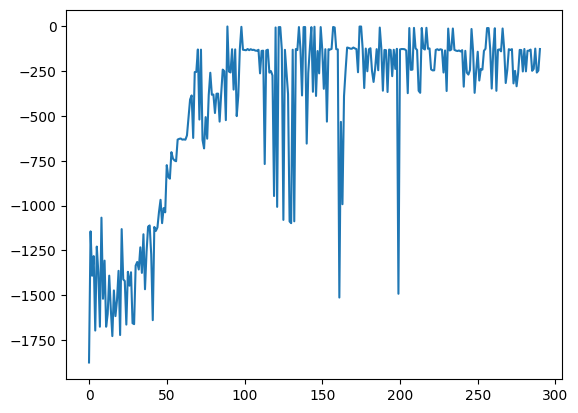

In [127]:
plt.plot(agent.avg_reward_history)

In [136]:
noise()

array([-0.01428082])